In [48]:
import pandas as pd
from pathlib import Path
import numpy as np

dataset_dir = Path(r"..\data\darts_positions")
annotation_dir = dataset_dir / "labels"
df = pd.DataFrame([np.loadtxt(f) for f in annotation_dir.glob("*.txt")])
df.columns = ["x", "y"]

In [49]:
df = df[(df["x"] < 1) & (df["y"] < 1) & (df["x"] > 0) & (df["y"] > 0)]
df.describe()

,x,y
count,5521.000000,5521.000000
mean,0.569995,0.577231
std,0.209124,0.210647
min,0.009029,0.003265
25%,0.445794,0.445484
50%,0.598432,0.614206
75%,0.706789,0.721424
max,0.999982,0.998865


<Axes: xlabel='x', ylabel='y'>

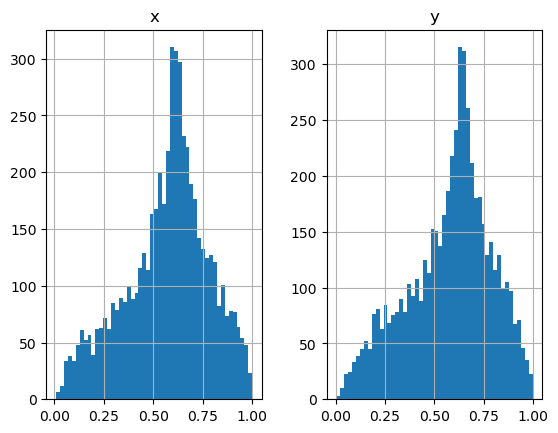

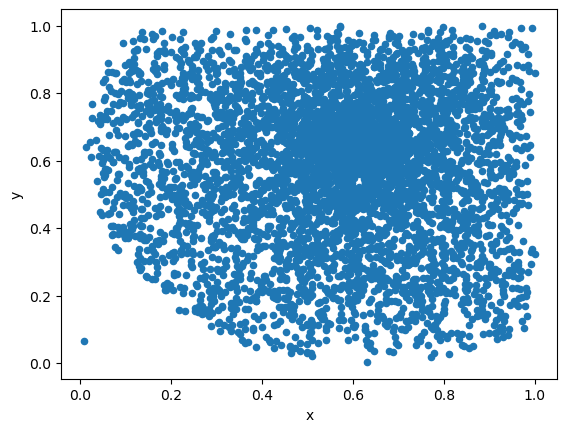

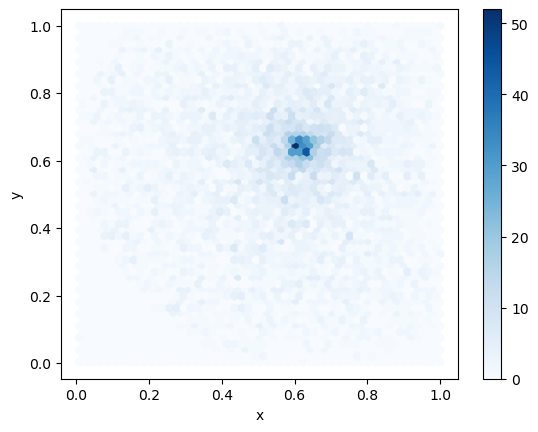

In [50]:
df.hist(bins=50)
df.plot.scatter(x="x", y="y")
df.plot.hexbin(x="x", y="y", gridsize=50, cmap="Blues")

Augmentation important, dataset is not really randomly distributed.

In [8]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, Dataset
import albumentations as A
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

In [59]:
def prepare_image(image: np.ndarray) -> torch.Tensor:
    """Prepare image for model input."""
    image = image.astype(np.float32) / 255.0
    image = np.expand_dims(image, axis=2)
    return torch.tensor(image, dtype=torch.float32)

In [37]:
class DartsDataset(Dataset):
    def __init__(self, label_dir: Path, img_dir: Path, transform=None):
        self.label_dir = label_dir
        self.img_dir = img_dir
        self.transform = transform

        self.img_paths = sorted(Path(img_dir).glob("*.jpg"))
        self.label_paths = sorted(Path(label_dir).glob("*.txt"))

        assert len(self.img_paths) == len(self.label_paths), (
            "Image and Label count mismatch!"
        )

        self.img_labels = pd.DataFrame([np.loadtxt(f) for f in self.label_paths])
        self.img_labels.columns = ["x", "y"]
        self.img_labels = self.img_labels[
            (self.img_labels["x"] < 1)
            & (self.img_labels["y"] < 1)
            & (self.img_labels["x"] > 0)
            & (self.img_labels["y"] > 0)
        ]

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        real_idx: int = int(self.img_labels.index[idx])  # type: ignore
        img_path = self.img_paths[real_idx]

        image = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        
        image = np.expand_dims(image, axis=2)
        h, w = image.shape[:2]
        
        label_path = self.label_paths[real_idx]
        coords = np.loadtxt(label_path).flatten()
        x_norm, y_norm = coords[0], coords[1]

        x_abs = x_norm * w
        y_abs = y_norm * h

        if self.transform:
            transformed = self.transform(image=image, keypoints=[[x_abs, y_abs]])
            image = transformed["image"]

            if len(transformed["keypoints"]) > 0:
                x_aug, y_aug = transformed["keypoints"][0]
            else:
                x_aug, y_aug = 0.5 * w, 0.5 * h

            new_h, new_w = image.shape[1], image.shape[2]

            x_final = np.clip(x_aug / new_w, 0.0, 1.0).item()
            y_final = np.clip(y_aug / new_h, 0.0, 1.0).item()

            target = torch.tensor([x_final, y_final], dtype=torch.float32)
        else:
            image = torch.from_numpy(image).float().permute(2, 0, 1) / 255.0
            target = torch.tensor([x_norm, y_norm], dtype=torch.float32)
            target = torch.tensor([x_norm, y_norm], dtype=torch.float32)

        return image, target

In [36]:
def show_image_with_point(image: torch.Tensor, point: torch.Tensor):
    plt.imshow(image.squeeze(), cmap='gray')
    plt.plot([point[0] * image.shape[1]], [point[1] * image.shape[2]], 'rx', markersize=10)
    plt.axis('off')
    plt.show()

In [40]:
dataset_dir = Path(r"..\data\darts_positions")
validation_images = dataset_dir / "images/val"
train_images = dataset_dir / "images/train"

validation_labels = dataset_dir / "labels/val"
train_labels = dataset_dir / "labels/train"

trainset = DartsDataset(
    label_dir=train_labels,
    img_dir=train_images,
    transform=A.Compose(
        [
            A.Resize(height=256, width=256, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Affine(translate_percent={"x": (-0.3, 0.3), "y": (-0.3, 0.3)}, p=0.8),
            A.ToFloat(max_value=255.0),
            A.pytorch.transforms.ToTensorV2(),
        ],
        keypoint_params=A.KeypointParams(format="xy"),
    ),
)
valset = DartsDataset(
    label_dir=validation_labels,
    img_dir=validation_images,
    transform=A.Compose(
        [
            A.Resize(height=256, width=256, p=1.0),
            A.ToFloat(max_value=255.0),
            A.pytorch.transforms.ToTensorV2(),
        ],
        keypoint_params=A.KeypointParams(format="xy"),
    ),
)

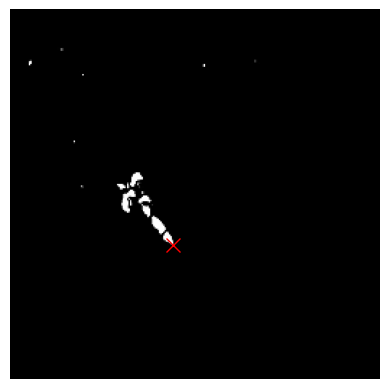

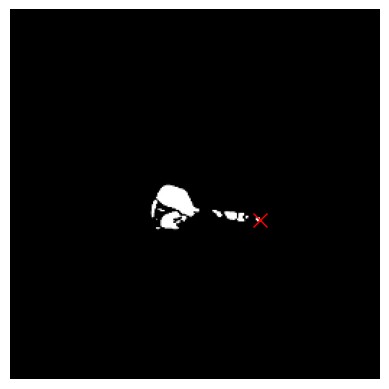

In [41]:
show_image_with_point(*trainset[0])
show_image_with_point(*valset[0])

In [93]:
class CNNModel(torch.nn.Module):
    def __init__(self, input_channels=1):
        super(CNNModel, self).__init__()
        in_dim = input_channels + 2
        self.features = nn.Sequential(
            # 1. Block with dilation (Increased receptive field)
            nn.Conv2d(in_dim, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 2. Block with dilation (Increased receptive field)
            nn.Conv2d(32, 64, kernel_size=3, padding=2, dilation=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 3. Block without dilation 
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )

        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 2),
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Inputs should be tensors in (B, C, H, W) format"""
        # https://arxiv.org/pdf/1807.03247
        batch_size, c, h, w = x.size()
        
                
        # Create coordinate grid [-1, 1]
        y_coords = torch.linspace(-1, 1, h, device=x.device)
        x_coords = torch.linspace(-1, 1, w, device=x.device)
        yy, xx = torch.meshgrid(y_coords, x_coords, indexing="ij")

        # Expand and Cat
        xx = xx.expand(batch_size, 1, h, w)
        yy = yy.expand(batch_size, 1, h, w)
        x = torch.cat([x, xx, yy], dim=1)
        
        # Forward pass through the network
        x = self.features(x)
        x = self.regressor(x)

        return x

In [98]:
model = CNNModel()
model(trainset[0][0].unsqueeze(0))

tensor([[0.5043, 0.5492]], grad_fn=<SigmoidBackward0>)

In [100]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0.0
    model.train()
    
    for batch, (img, label) in enumerate(dataloader):
        x, y = img.to(device), label.to(device)

        # Forward pass
        pred = model(x)

        # Compute loss
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if batch % 10 == 0:
            print(f"Batch {batch}/{len(dataloader)} | Loss: {loss.item():.6f}")

    train_loss /= num_batches
    return train_loss

def test_loop(dataloader, model, loss_fn, device):
    num_batches = len(dataloader)
    test_loss = 0.0
    mean_distance = 0.0
    
    model.eval()
    
    with torch.no_grad():
        for img, label in dataloader:
            x, y = img.to(device), label.to(device)

            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            dist = torch.sqrt(torch.sum((pred - y)**2, dim=1))
            mean_distance += dist.mean().item()

    test_loss /= num_batches
    mean_distance /= num_batches
    return test_loss, mean_distance

In [101]:
train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(valset, batch_size=32, shuffle=False, num_workers=4)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = CNNModel().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

Using cpu device


In [ ]:
epochs = 20
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_loss = train_loop(train_loader, model, loss_fn, optimizer, device)
    val_loss, val_mean_distance = test_loop(val_loader, model, loss_fn, device)
    print(f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | Val Mean Distance: {val_mean_distance:.6f}\n")

Epoch 1/20
